## Problem 2 - The Dishonest Casino
- João Braz, 60419
- Joel Oliveira, 59442

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import LabelEncoder

In [2]:
with open("rolls.txt", "r") as f:
    X = list(
        map(lambda x: int(x.strip("\n")), f.readlines())
    )
    X = np.array(X).reshape(-1,1)-1
    f.close()

with open("dice.txt", "r") as f:
    y = list(map(lambda x: x.strip("\n"), f.readlines()))
    #y = np.array(y).reshape(-1,1)
    enc = LabelEncoder().fit(y)
    y = enc.transform(y).reshape(-1,1)

In [3]:
def train_test_split( arrays: list, test_size):
    out = []
    for arr in arrays:
        arr_train, arr_test = arr[:test_size], arr[test_size:]
        out.append(arr_train)
        out.append(arr_test)
    return out

In [4]:
X_train, X_test, y_train, y_test = train_test_split((X, y), -10)

### a) construct the model assuming all parameters known.

- Creation of model with all known parameters

In [5]:
model = hmm.CategoricalHMM(n_components=2, init_params="mcs")
model.n_features=6
model.transmat_ = np.array([[0.95, 0.05],
                            [0.1, 0.9]])
model.emissionprob_ = np.array([[1/6]*6,
                                [1/10]*5 + [1/2]])
model.startprob_ = np.array([1.0, 0.0])

- Creation of model with unknown transition probability matrix

In [6]:
remodel = hmm.CategoricalHMM(n_components=2, init_params="mcts", n_iter=10000000)
remodel.n_features=6

remodel.emissionprob_ = np.array([[1/6]*6,
                                [1/10]*5 + [5/10]])

In [7]:
remodel.fit(X_train)
remodel.monitor_.converged

True

In [8]:
remodel.startprob_

array([1.00000000e+00, 8.09629784e-19])

In [9]:
remodel.score(X_test), model.score(X_test)

(-18.02663100633051, -18.228865102347154)

The scores are similar

- Comparison of real and estimated transition matrix

In [10]:
remodel.transmat_

array([[0.97115183, 0.02884817],
       [0.07606064, 0.92393936]])

The transition matrix made good convergence towards the true matrix when the number of iterations got higher. <br>
When the number of iterations was small it probably depended a lot in the initial values. <br>
By setting the iterations higher a good enough transition matrix was created more often.

- Comparison of the generated dice series **VS** the original dice series

In [11]:
roll_series_generated, dice_state = remodel.sample(10)

In [12]:
def bar(x,y,ax, xlabel="", ylabel="", title="", label="", legend=False):
    ax.bar(x,y, ec='k', label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if legend:
        ax.legend()

In [13]:
generated_dict = dict(
    sorted(
        zip(
            *np.unique(roll_series_generated, return_counts=True)), 
            key=lambda x: x[0]
    )
)

true_dict = dict(
    sorted(
        zip(*np.unique(X_test, return_counts=True)),
        key=lambda x: x[0]
    )
)

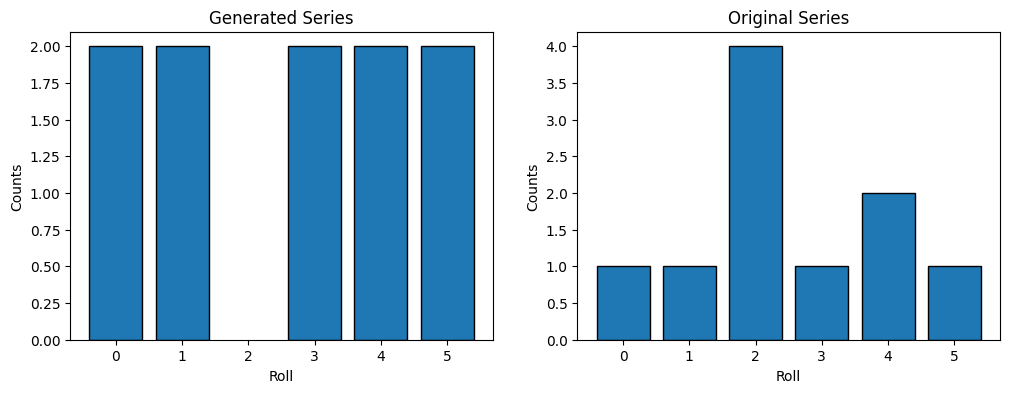

In [14]:
f, ax = plt.subplots(1,2,figsize=(12,4))

bar(generated_dict.keys(), generated_dict.values(), ax[0], "Roll", "Counts", "Generated Series")
bar(true_dict.keys(), true_dict.values(), ax[1], "Roll", "Counts", "Original Series")

In [15]:
print(np.concatenate((dice_state.reshape(-1,1), y_test), axis=1))

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


We can see that the frequencies of the Validation set are relatively uniform, and the generated series are very similar. <br>

Besides that we can see that the state did not change, just like in the original set. 


----

### c) Train HMM’s with half of the data points and observe the log-likelihood with the remaining half. 
- Compare the estimated parameters (transition and emission matrices) with the original model from question a);
- Visualize the generated dice series of the last half of data against the given one. <br>
(Note: Use the dataset provided in files rolls.txt and dice.txt provided on Moodle);

In [16]:
N = X.shape[0]//2

In [17]:
X_train, X_test, y_train, y_test = train_test_split((X, y), N)

####    1. Assume both transition and emission matrices are unknown

In [18]:
def super_bar(x, yy, labels, ax, xlabel="", ylabel="", title=""):
    temp = pd.DataFrame(
        index=x, 
        data=dict(zip(labels,yy))
    )
    temp.plot.bar( ax=ax, xlabel=xlabel, ylabel=ylabel, ec="k")
    ax.set_title(title)

In [19]:
remodel = hmm.CategoricalHMM(n_components=2, n_iter=10000000, init_params="mtecs")
remodel.n_features=6
remodel.fit(X_train)
remodel.monitor_.converged

True

In [20]:
remodel.score(X_test), model.score(X_test)

(-969.6146432684814, -961.4177962080355)

Like before, the log-likelihood scores are not very distinct from each other. <br>
The original model performed better

In [21]:
np.round(remodel.transmat_, 2)

array([[0.8 , 0.2 ],
       [0.06, 0.94]])

The transition matrix estimated approachedd the original matrix with less frequency. The number of iterations was increased to increase the number of times this occured. <br>

In [22]:
model_probs = np.round(remodel.emissionprob_, decimals=2)

In [23]:
true_probs = np.round(model.emissionprob_, decimals=2)

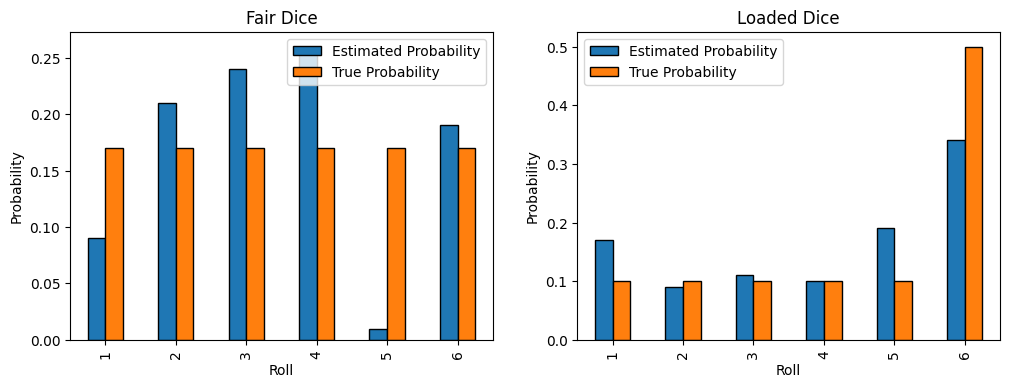

In [24]:
f, ax = plt.subplots(1,2, figsize=(12,4))

super_bar(range(1,7), [model_probs[0],true_probs[0]], ["Estimated Probability", "True Probability"], ax[0], xlabel="Roll", ylabel="Probability", title="Fair Dice")
super_bar(range(1,7), [model_probs[1],true_probs[1]], ["Estimated Probability", "True Probability"], ax[1], xlabel="Roll", ylabel="Probability", title="Loaded Dice")

When the states are accuratly estimated, we see that the emissions are also related. When this does not happen, the emissions seem to be accuratly predicted, but reversed. This is, the probabilities of the Loaded Dice are estimated for the Fair Dice, and the ones from the Fair Dice are estimated for the Loaded Dice

In [25]:
def steps(x,y, ax, xlabel="", ylabel="", title=""):
    ax.plot(x,y, drawstyle="steps")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

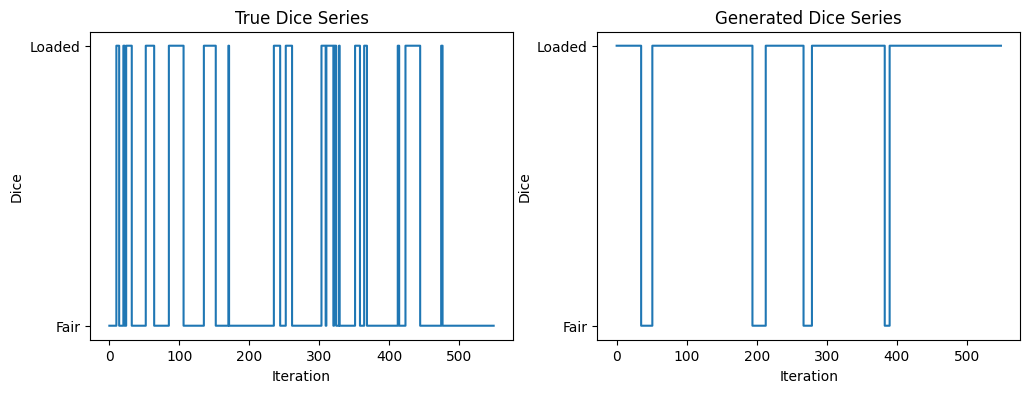

In [26]:
f, ax = plt.subplots(1,2, figsize=(12,4))

steps(range(N), y_test, ax[0], "Iteration", "Dice", "True Dice Series")
steps(range(N), remodel.predict(X_test), ax[1], "Iteration", "Dice", "Generated Dice Series")

ax[0].set_yticks([0,1])
ax[0].set_yticklabels(["Fair", "Loaded"]);

ax[1].set_yticks([0,1])
ax[1].set_yticklabels(["Fair", "Loaded"]);

In [27]:
(y_test.ravel() == remodel.predict(X_test)).sum() / y_test.shape[0]

0.3509090909090909

Low accuracy, of 35%

#### 2. Assume all the parameters unknown, including the number of states 
(suggestion: try with the number of states from 1 to 4 and compare the resulting log-likehoods).

In [28]:
scores = []
for i in range(1,5):
    remodel = hmm.CategoricalHMM(n_components=i, n_iter=10000000, init_params="mtec")
    remodel.n_features=6
    remodel.startprob_ = np.array([1.0]+[0]*(i-1))
    remodel.fit(X_train)
    print(remodel.monitor_.converged)
    
    scores.append(remodel.score(X_test))
    
    print("Transition Matrices:")
    print(np.round(remodel.transmat_,2))
    
    print()
    print("-"*15)
    
    print("Emission Matrix:")
    print(np.round(remodel.emissionprob_, 2))
    
    print()
    print("#"*15)
    print("#"*15+"\n")

True
Transition Matrices:
[[1.]]

---------------
Emission Matrix:
[[0.15 0.12 0.14 0.14 0.15 0.31]]

###############
###############

True
Transition Matrices:
[[0.41 0.59]
 [0.88 0.12]]

---------------
Emission Matrix:
[[0.18 0.18 0.2  0.08 0.15 0.22]
 [0.1  0.03 0.06 0.23 0.15 0.43]]

###############
###############

True
Transition Matrices:
[[0.35 0.18 0.47]
 [0.96 0.03 0.01]
 [0.34 0.5  0.16]]

---------------
Emission Matrix:
[[0.11 0.12 0.03 0.25 0.2  0.29]
 [0.29 0.2  0.2  0.01 0.01 0.28]
 [0.09 0.04 0.29 0.04 0.17 0.37]]

###############
###############

True
Transition Matrices:
[[0.45 0.35 0.   0.2 ]
 [0.01 0.57 0.42 0.  ]
 [0.91 0.   0.   0.09]
 [0.   0.   1.   0.  ]]

---------------
Emission Matrix:
[[0.31 0.09 0.17 0.18 0.   0.24]
 [0.01 0.27 0.1  0.17 0.02 0.43]
 [0.13 0.   0.21 0.08 0.21 0.37]
 [0.   0.03 0.   0.   0.96 0.  ]]

###############
###############



In [29]:
scores

[-969.3308570167918,
 -969.7196938676874,
 -972.6394721279129,
 -984.3701256360328]

The model with the highest score was not always the one with 2 components. <br>

Besides that, the scores were all relatively close with each other.

### d) Generate 30000 samples from the model of question a). Repeat question c) using this new dataset. 
(Note: you don’t need to visualize the dice states.)

In [30]:
new_X, new_y = model.sample(30000)

- #### Repeat question c)

In [31]:
N = new_X.shape[0]//2

In [32]:
X_train, X_test, y_train, y_test = train_test_split((new_X, new_y), N)

#### 1. With transition and emission matrices unknown

In [53]:
remodel = hmm.CategoricalHMM(n_components=2, init_params="mctes", n_iter=10000000)
remodel.n_features=6
remodel.fit(X_train)
remodel.monitor_.converged

True

In [54]:
remodel.score(X_test), model.score(X_test)

(-26155.7429818944, -26143.482330643787)

In [55]:
remodel.transmat_

array([[0.95015465, 0.04984535],
       [0.11112278, 0.88887722]])

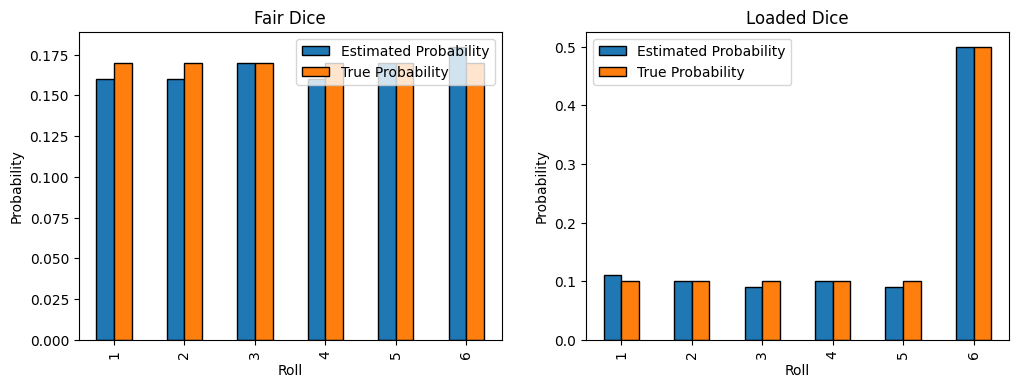

In [56]:
model_probs = np.round(remodel.emissionprob_, decimals=2)
true_probs = np.round(model.emissionprob_, decimals=2)

f, ax = plt.subplots(1,2, figsize=(12,4))

super_bar(range(1,7), [model_probs[0],true_probs[0]], ["Estimated Probability", "True Probability"], ax[0], xlabel="Roll", ylabel="Probability", title="Fair Dice")
super_bar(range(1,7), [model_probs[1],true_probs[1]], ["Estimated Probability", "True Probability"], ax[1], xlabel="Roll", ylabel="Probability", title="Loaded Dice")

It seems that the model converges more often to the right transition probabilities than with the "roll.txt" dataset. <br>
Since the sample size is bigger it can infer the probabilities better.

When the transitions probabilities are well estimated, the emission probabilities are usually accurate.

In [57]:
true_dice = dict(zip(*np.unique(y_test, return_counts=True)))

In [58]:
estimated_dice = dict(zip(*np.unique(remodel.predict(X_test), return_counts=True)))

[Text(0, 0, 'Fair'), Text(1, 0, 'Loaded')]

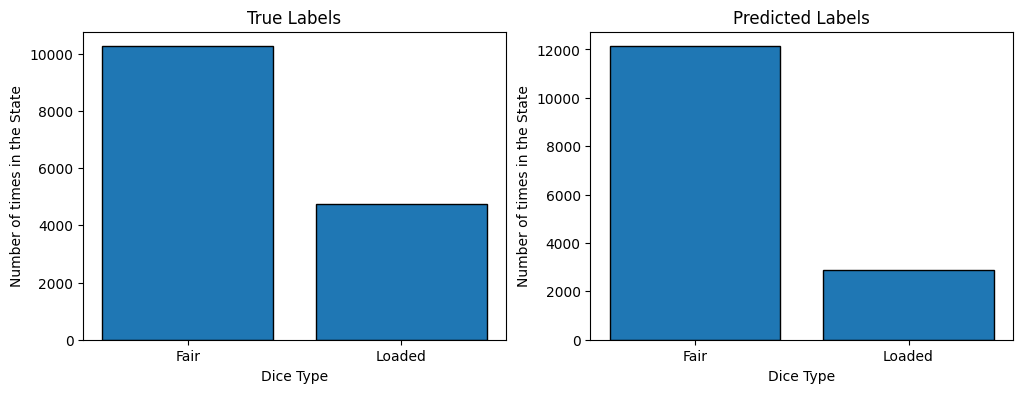

In [59]:
f, ax = plt.subplots(1,2, figsize=(12,4))

bar(true_dice.keys(), true_dice.values(), ax[0], "Dice Type", "Number of times in the State", "True Labels")
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(["Fair", "Loaded"])

bar(estimated_dice.keys(), estimated_dice.values(), ax[1], "Dice Type", "Number of times in the State", "Predicted Labels")
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(["Fair", "Loaded"])

In [60]:
(y_test==remodel.predict(X_test)).sum() / y_test.shape[0]

0.8076

It seems as the proportions of each state is similar in the validation set and in the prediction set.

The accuracy is way better than with the "rolls.txt" dataset

#### 2. With all parameters unknown

In [61]:
scores = []
for i in range(1,5):
    remodel = hmm.CategoricalHMM(n_components=i, n_iter=10000000, init_params="mcste")
    remodel.n_features=6
    #remodel.startprob_ = np.array([1.0]+[0]*(i-1))
    remodel.fit(X_train)
    print(remodel.monitor_.converged)
    
    scores.append(remodel.score(X_test))
    
    print("Transition Matrices:")
    print(np.round(remodel.transmat_,2))
    
    print()
    print("-"*15)
    
    print("Emission Matrix:")
    print(np.round(remodel.emissionprob_, 2))
    
    print()
    print("#"*15)
    print("#"*15+"\n")

True
Transition Matrices:
[[1.]]

---------------
Emission Matrix:
[[0.14 0.14 0.15 0.14 0.15 0.28]]

###############
###############

True
Transition Matrices:
[[0.86 0.14]
 [0.83 0.17]]

---------------
Emission Matrix:
[[0.14 0.16 0.17 0.17 0.05 0.31]
 [0.16 0.01 0.05 0.   0.72 0.06]]

###############
###############

True
Transition Matrices:
[[0.95 0.04 0.01]
 [0.08 0.47 0.45]
 [0.17 0.77 0.05]]

---------------
Emission Matrix:
[[0.15 0.16 0.17 0.16 0.17 0.18]
 [0.15 0.05 0.02 0.14 0.08 0.55]
 [0.02 0.19 0.22 0.02 0.11 0.44]]

###############
###############

True
Transition Matrices:
[[0.46 0.   0.41 0.13]
 [0.62 0.01 0.18 0.2 ]
 [0.03 0.9  0.07 0.  ]
 [0.   0.05 0.   0.95]]

---------------
Emission Matrix:
[[0.1  0.14 0.03 0.14 0.04 0.55]
 [0.18 0.03 0.   0.12 0.12 0.55]
 [0.05 0.11 0.26 0.01 0.13 0.43]
 [0.15 0.16 0.18 0.16 0.17 0.18]]

###############
###############



In [62]:
scores

[-26346.195807969463,
 -26344.540939592516,
 -26159.441044046573,
 -26169.654697140966]

Likewise the model with the best score was not always the one that should be (the one with 2 components). Both the one with 3 and the one with 4 components also had decent scores